In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.ndimage as nd
import cv2
from skimage import filters
from scipy.linalg import lstsq

In [2]:
traffic0 = cv2.imread("C:/Users/jack_/Downloads/traffic0.png", 0)
traffic1 = cv2.imread("C:/Users/jack_/Downloads/traffic1.png", 0)

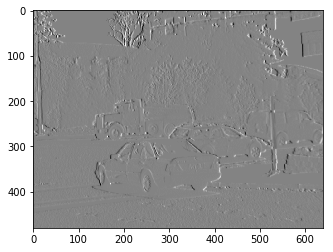

In [3]:
#calculate partial derivatives of test image
deriv_x = filters.sobel_v(traffic0)
deriv_y = filters.sobel_h(traffic0)
plt.imshow(deriv_x, cmap="gray")

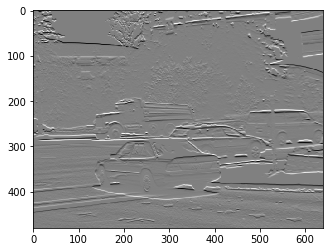

In [4]:
plt.imshow(deriv_y, cmap="gray")

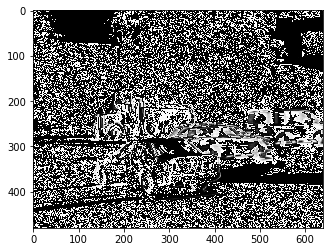

In [5]:
temporal_deriv = traffic1 - traffic0
plt.imshow(temporal_deriv, cmap="gray")

In [7]:
#Horn-Schunck algorithm
#initialize vectors u and v to an array of zeros of the same shape as the derivative images
rows = deriv_x.shape[0]
cols = deriv_x.shape[1]
u = np.zeros((rows, cols))
v = np.zeros((rows, cols))
iterations = 0
#variable which is to store the energy cost of the previous iteration 
old_cost = 100000
converged = False
gamma = 100
while iterations < 500 and converged == False:
    cost = 0
    for i in range(rows):
        for j in range(cols):
            #check whether indices i and j fall outside the boundaries of the vectors u,v
            #if they do, set the corresponding value of the vectors to zero
            if i == rows - 1:
                u1 = 0
                v1 = 0
            else:
                u1 = u[i+1][j]
                v1 = v[i+1][j]
            if i < 0:
                u2 = 0
                v2 = 0
            else:
                u2 = u[i-1][j]
                v2 = v[i-1][j]
            if j == cols - 1:
                u3 = 0
                v3 = 0
            else:
                u3 = u[i][j+1]
                v3 = v[i][j+1]
            if j < 0:
                u4 = 0
                v4 = 0
            else:
                u4 = u[i][j-1]
                v4 = v[i][j-1]
            #compute vbar and ubar to be used to update the values of u and v at the current index
            ubar = 0.25*(u1+u2+u3+u4)
            vbar = 0.25*(v1+v2+v3+v4)
            numerator1 = deriv_x[i][j]*(deriv_x[i][j]*ubar + deriv_y[i][j]*vbar + temporal_deriv[i][j])
            numerator2 = deriv_y[i][j]*(deriv_x[i][j]*ubar + deriv_y[i][j]*vbar + temporal_deriv[i][j])
            denominator = np.square(gamma) + np.square(deriv_x[i][j]) + np.square(deriv_y[i][j])
            #update the values of u and v at the current index following the appropriate formula
            u[i][j] = ubar - (numerator1/denominator)
            v[i][j] = vbar - (numerator2/denominator)
            #calculate smoothness and brightness constancy in order to compute the total cost at the iteration
            smoothness = 0.25*(np.square(u[i][j]-u1) + np.square(u[i][j]-u3) + np.square(v[i][j]-v1) + np.square(v[i][j]-v3))
            brightness_constancy = np.square(deriv_x[i][j]*u[i][j] + deriv_y[i][j]*v[i][j] + temporal_deriv[i][j])
            cost += (smoothness + gamma*brightness_constancy)
    #check whether the difference between the cost of the previous iteration and the current cost is minimal
    #if it is, convergence has been achieved
    if np.abs(old_cost - cost) < 0.1:
        converged = True
    #set the current cost to be the previous cost
    old_cost = cost
    iterations += 1

In [36]:
print(iterations)

1000


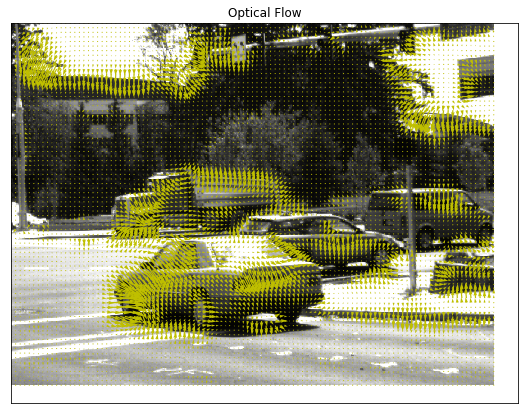

In [12]:
# Subsample the vector field to make it less dense
subsample = 6
rows = u.shape[0]
cols = u.shape[1]
sub_u = u[0:rows:subsample, 0:cols:subsample]
sub_v = -v[0:rows:subsample, 0:cols:subsample]
xc = np.linspace(0, cols, sub_u.shape[1])
yc = np.linspace(0, rows, sub_u.shape[0])
# Locations of the vectors
xv, yv = np.meshgrid(xc, yc)
fig1 = plt.figure(figsize = (14,7))
plt.imshow(traffic0,cmap = 'gray')
plt.title('Optical Flow'), plt.xticks([]), plt.yticks([])
# Plot the vectors
plt.quiver(xv, yv, sub_u, sub_v, color='y')